# Test learner

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile

import torchvision

import geffnet # efficient/ mobile net

In [3]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_databunch(sz=sz, bs=bs, crappy_path=path_lowRes, 
                         good_path=path_fullRes, 
                         random_seed=None, keep_pct=keep_pct)

In [4]:
path = untar_data(URLs.PETS)

path_fullRes = path/'images'
path_lowRes = path/'lowRes-96'
path_medRes = path/'lowRes-256'

proj_id = 'unet_superRes'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 2
pct_start = 1e-8

In [5]:
bs=25
sz=128
lr = 1e-3
wd = 1e-3
keep_pct=1.0
epochs = 10

In [6]:
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)

In [8]:
model = geffnet.mobilenetv3_100

In [9]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=FeatureLoss(),
                             arch = model,
                             nf_factor=nf_factor)

In [23]:
learn_gen.load("unet_superRes_gen_256px_1");

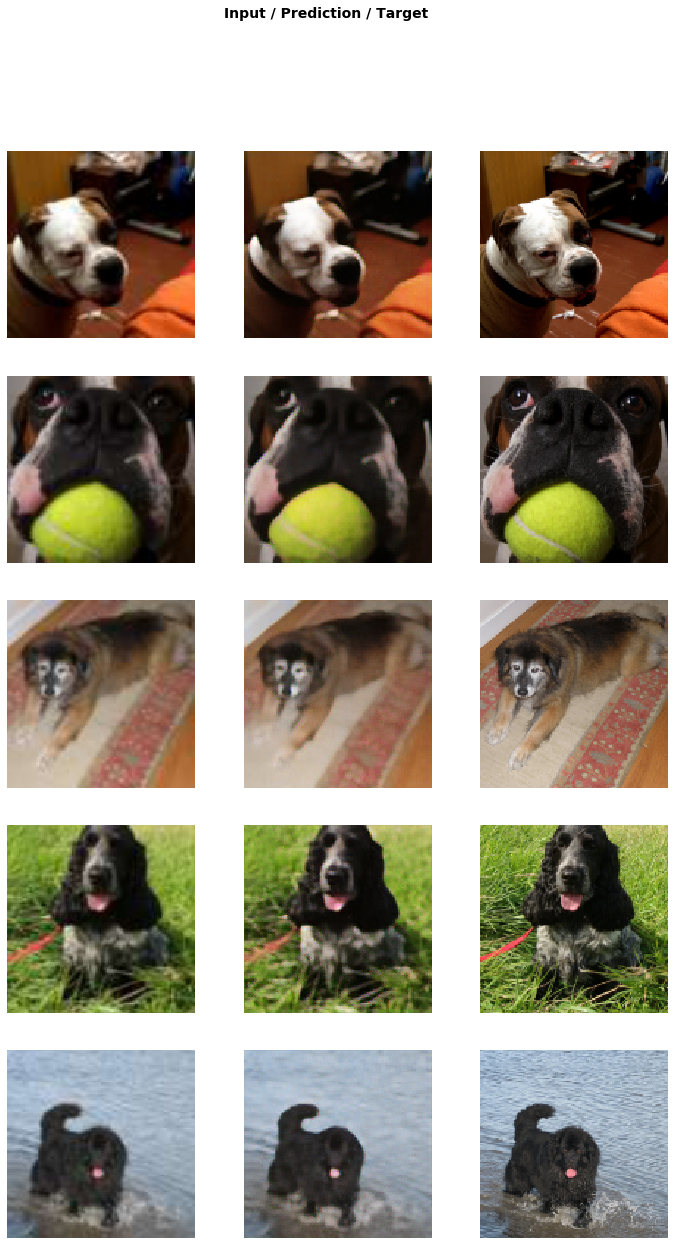

In [24]:
learn_gen.show_results()

In [ ]:
data_mr = (ImageImageList.from_folder(path_medRes).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_fullRes/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3
learn_gen.load(pre_gen_name)
learn_gen.data = data_mr
fn = data_mr.valid_ds.x.items[0]; fn
img = open_image(fn); img.shape
p,img_hr,b = learn_gen.predict(img)
show_image(img, figsize=(18,15));
gen_img = torchvision.transforms.functional.to_pil_image(img_hr)
show_image(gen_img,figsize=(18,15));